<a href="https://colab.research.google.com/github/psahai10/AIFellowship/blob/main/starbucks_uplift_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from IPython.display import display, HTML
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import xgboost
from tqdm import tqdm
tqdm.pandas()


#import causallift
#from causallift import CausalLift


from itertools import combinations
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read in the json files
portfolio = pd.read_json('/content/drive/My Drive/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/content/drive/My Drive/profile.json', orient='records', lines=True)
transcript = pd.read_json('/content/drive/My Drive/transcript.json', orient='records', lines=True)

In [ ]:
def explore_data(df):
    print(str())
    display(df.head())
    display(df.shape)
    display(df.dtypes)
    display(np.sum(df.isnull()))
    display(df.describe())
    print("-------------------------------")

In [ ]:
display(explore_data(transcript))

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


(306534, 4)

person    object
event     object
value     object
time       int64
dtype: object

person    0
event     0
value     0
time      0
dtype: int64

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


-------------------------------


None

In [ ]:
transcript = transcript.rename(columns={'person': 'id'})

transcript.head()

,id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [ ]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [ ]:
from pandas.io.json import json_normalize
normalized_value = json_normalize(transcript['value'])

normalized_value.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
5,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
6,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN
7,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
9,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


In [ ]:
normalized_value['offer id'].value_counts()

2298d6c36e964ae4a3e7e9706d1fb8c2    14983
fafdcd668e3743c1bb461111dcafc2a4    14924
4d5c57ea9a6940dd891ad53e9dbe8da0    14891
f19421c1d4aa40978ebb69ca19b0e20d    14835
ae264e3637204a6fb9bb56bc8210ddfd    14374
5a8bc65990b245e5a138643cd4eb9837    14305
9b98b8c7a33c4b65b9aebfe6a799e6d9    11848
3f207df678b143eea3cee63160fa8bed    11761
2906b810c7d4411798c6938adc9daaa5    11750
0b1e1539f2cc45b7b9fa7c272da2e1d7    10331
Name: offer id, dtype: int64

In [ ]:
normalized_value['offer_id'] = normalized_value['offer_id'].fillna(normalized_value['offer id'])
normalized_value = normalized_value.drop(columns=['offer id'], axis=1)

In [ ]:

transcript = transcript.merge(normalized_value, left_index=True, right_index=True).drop(columns=['value', 'reward'], axis=1)

transcript.head()

,id,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [ ]:
# amount column relates to 'transaction' event value
transcript[~transcript.amount.isnull()].head()

,id,event,time,amount,offer_id
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97,NaN


In [ ]:
display(explore_data(profile))

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


(17000, 5)

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


-------------------------------


None

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


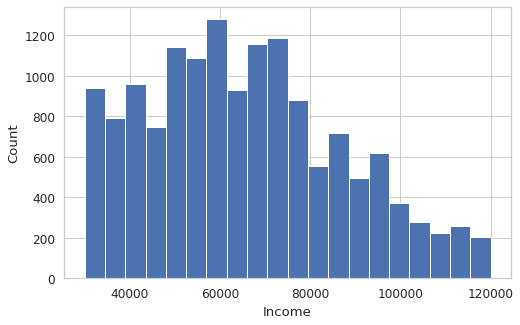

In [ ]:
import seaborn as sns

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    profile['income'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Income', ylabel='Count');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


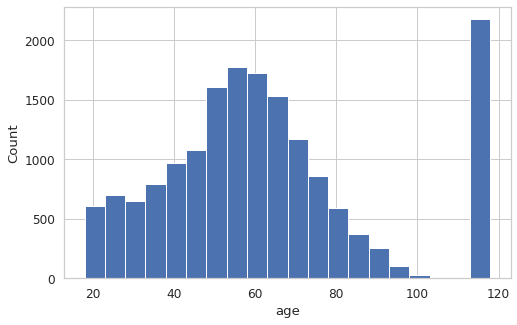

In [ ]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    profile['age'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='age', ylabel='Count');

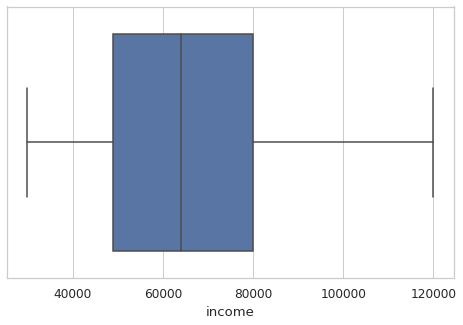

In [ ]:
sns.boxplot(x=profile['income'])
#profile.boxplot(column=['income'])

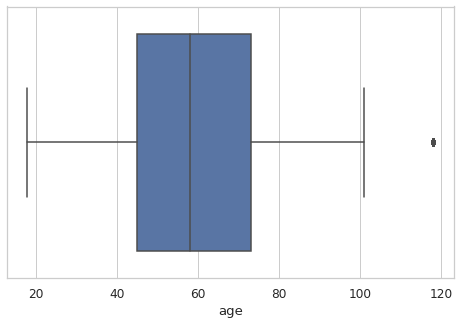

In [ ]:
sns.boxplot(x=profile['age'])

In [ ]:
from datetime import datetime, timedelta

def days_from_today(date):
        delta = datetime.today() - date
        days = delta.days
        return days

profile['became_member_on'] = profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
profile['days_as_member'] = profile['became_member_on'].apply(days_from_today)

profile.head()

,gender,age,id,became_member_on,income,days_as_member
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1487
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1334
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,972
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1401
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,1314


In [ ]:
display(explore_data(portfolio))

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


(10, 6)

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


-------------------------------


None

In [ ]:
portfolio = portfolio.rename(columns={'id': 'offer_id'})


# fill null values in order to avoid error for when splitting the list into individual column values per channel        
portfolio.channels = portfolio.channels.fillna('None')

for element in ['web', 'email', 'mobile', 'social']:
    portfolio[element] = portfolio.channels.apply(lambda x: x.count(element))

portfolio = portfolio.drop(columns=['channels'], axis=1)

In [ ]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


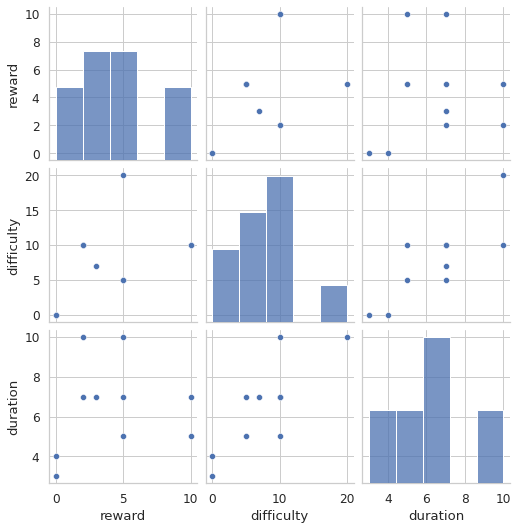

In [ ]:
sns.pairplot(portfolio[['reward', 'difficulty', 'duration']]);

In [ ]:
df = transcript.merge(profile, on='id')

df = df.merge(portfolio, on='offer_id', how='left')
    
df.head()

,id,event,time,amount,offer_id,gender,age,became_member_on,income,days_as_member,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1401,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1401,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,F,75,2017-05-09,100000.0,1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,1401,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,F,75,2017-05-09,100000.0,1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
  # df = pd.read_csv(data_filepath, parse_dates = ['became_member_on'])
  # df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
  # df = df.loc[df.event == 'offer received']

In [ ]:
id_list = df.id.unique().tolist()[:3]

for id_ in id_list:
    id_df = df.loc[df['id'].isin([id_])]
    id_df = id_df[['event', 'offer_type', 'id', 'time', 'duration', "offer_id"]].sort_values(by=['id', 'time'])
    
    id_received_df = id_df.loc[id_df['event'] == 'offer received'].reset_index()
    
    print("id: {}".format(id_))
    
    for i in range(id_received_df.shape[0]):
        offer_id = id_received_df.offer_id[i]
        offer_type = id_received_df.offer_type[i]
        time = id_received_df.time[i]
        duration = id_received_df.duration[i]
        max_time = time + duration
        timeframe = id_df.loc[(id_df['time'] >= time) & (id_df['time'] <= max_time) & (id_df['offer_id'] == offer_id)].reset_index()
        if timeframe.event.unique().tolist().count('offer viewed') > 0:
            print("YES (treatment)- {} offer received at {} was viewed".format(offer_type, time))
        else:
            print("NO (treatment) - {} offer received at {} was not reedemed".format(offer_type, time))
        if timeframe.event.unique().tolist().count('transaction') > 0:
            print("YES (outcome)- a purchase occured within the duration of {} offer received at {}".format(offer_type, time))
        else:
            print("YES (outcome)- a purchase occured within the duration of {} offer received at {}".format(offer_type, time))
        
    print("----------\n")

id: 78afa995795e4d85b5d9ceeca43f5fef
YES (treatment)- bogo offer received at 0 was viewed
YES (outcome)- a purchase occured within the duration of bogo offer received at 0
NO (treatment) - informational offer received at 168 was not reedemed
YES (outcome)- a purchase occured within the duration of informational offer received at 168
YES (treatment)- bogo offer received at 408 was viewed
YES (outcome)- a purchase occured within the duration of bogo offer received at 408
NO (treatment) - bogo offer received at 504 was not reedemed
YES (outcome)- a purchase occured within the duration of bogo offer received at 504
----------

id: a03223e636434f42ac4c3df47e8bac43
YES (treatment)- discount offer received at 0 was viewed
YES (outcome)- a purchase occured within the duration of discount offer received at 0
YES (treatment)- informational offer received at 336 was viewed
YES (outcome)- a purchase occured within the duration of informational offer received at 336
NO (treatment) - informational o

In [ ]:
timeframe

,index,event,offer_type,id,time,duration,offer_id
0,36,offer received,discount,e2127556f4f64592b11af22de27a7932,504,10.0,fafdcd668e3743c1bb461111dcafc2a4


In [ ]:
link = 'https://raw.githubusercontent.com/taylorplumer/starbucks-uplift/master/data/processed_data_11202019.csv'
def load_data(data_filepath):
    """
    Load data from flat file 
    Args:
        data_filepath: path where flat csv file is located
    Returns:
        df: dataframe of flat file
    """
    df = pd.read_csv(data_filepath, parse_dates = ['became_member_on'])
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[df.event == 'offer received']
    return df
df = load_data(link)
df.head()

,event,id,time,age,became_member_on,gender,income,amount,offer_id,reward,days_as_member,difficulty,duration,offer_type,web,email,mobile,social,max_time,outcome,treatment
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,75,2017-05-09,F,100000.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,923,5.0,7.0,bogo,1,1,1,0,7.0,0.0,1.0
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,75,2017-05-09,F,100000.0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,923,0.0,3.0,informational,0,1,1,1,171.0,0.0,0.0
10,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,75,2017-05-09,F,100000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,923,10.0,7.0,bogo,0,1,1,1,415.0,0.0,1.0
12,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,75,2017-05-09,F,100000.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,923,5.0,5.0,bogo,1,1,1,1,509.0,0.0,0.0
18,offer received,a03223e636434f42ac4c3df47e8bac43,0,118,2017-08-04,NaN,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,836,20.0,10.0,discount,1,1,0,0,10.0,0.0,1.0


In [ ]:
np.sum(df.isnull()/ df.shape[0])

event               0.000000
id                  0.000000
time                0.000000
age                 0.000000
became_member_on    0.000000
gender              0.128164
income              0.128164
amount              1.000000
offer_id            0.000000
reward              1.000000
days_as_member      0.000000
difficulty          0.000000
duration            0.000000
offer_type          0.000000
web                 0.000000
email               0.000000
mobile              0.000000
social              0.000000
max_time            0.000000
outcome             0.000000
treatment           0.000000
dtype: float64

In [ ]:
# rows where income and gender values are null will be dropped since it only represent ~13%.
df = df.dropna(subset=['income', 'gender'])

In [ ]:
pd.crosstab(df['treatment'], df['outcome'], margins=True)

outcome,0.0,1.0,All
treatment,,,
0.0,46912,4519,51431
1.0,12207,2863,15070
All,59119,7382,66501


In [ ]:
# create target_class to indicate which segment event belongs to

df['target_class'] = 0 # Default set to Control Non-Responders where both treatment and outcome are 0. # LOST CAUSES
df.loc[(df.treatment == 0) & (df.outcome ==1),'target_class'] = 1 # Control Responders #PURSUADABLES
df.loc[(df.treatment == 1) & (df.outcome  ==0),'target_class'] = 2 # treatment Non-Responders # DO NOT DISTURB
df.loc[(df.treatment == 1) & (df.outcome  ==1),'target_class'] = 3 # treatment Responders # TREATMETN RESPONDERS

In [ ]:
class_dict = {0:'Control Non-Responder', 1: 'Control Responder', 2: 'Treatment Non-Responder', 3: 'Treatment Responder'}
classes = ['Control Non-Responder', 'Control Responder', 'Treatment Non-Responder', 'Treatment Responder']

In [ ]:
df.target_class.value_counts()

0    46912
2    12207
1     4519
3     2863
Name: target_class, dtype: int64

In [ ]:
# Remaining cleaning of the data will be done to then have it ready for model building.
def clean_data(df): 
    """
    Perform remaning feature engineering 
    Args:
        df: dataframe
    Returns:
        df: dataframe ready for model building
    """
    # drop non-relevant features for model building purposes        
    df = df.drop(columns=['id','event', 'time', 'became_member_on', 'amount', 'offer_id', 'reward', 'max_time' ], axis=1)
    # subset categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    return df
clean_df = clean_data(df)

clean_df.head()

,age,income,days_as_member,difficulty,duration,web,email,mobile,social,outcome,treatment,target_class,gender_M,gender_O,offer_type_discount,offer_type_informational
0,75,100000.0,923,5.0,7.0,1,1,1,0,0.0,1.0,2,0,0,0,0
5,75,100000.0,923,0.0,3.0,0,1,1,1,0.0,0.0,0,0,0,0,1
10,75,100000.0,923,10.0,7.0,0,1,1,1,0.0,1.0,2,0,0,0,0
12,75,100000.0,923,5.0,5.0,1,1,1,1,0.0,0.0,0,0,0,0,0
29,68,70000.0,571,10.0,7.0,1,1,1,0,0.0,0.0,0,1,0,1,0


### I. First train_test_split:

In [ ]:
train_df, test_df = train_test_split(clean_df, test_size=0.3, random_state=42)

In [ ]:
X_train = train_df.drop(columns=['treatment', 'outcome','target_class'], axis=1)
y_train = train_df.target_class

X_test = test_df.drop(columns=['treatment', 'outcome','target_class'], axis=1)
y_test = test_df.target_class

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


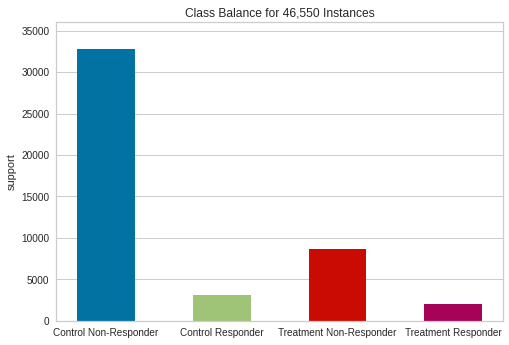

In [ ]:
from yellowbrick.target import ClassBalance, class_balance
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ConfusionMatrix


y = pd.Series(y_train).map(class_dict).values
# visualizer = ClassBalance(labels=classes)
# visualizer.fit(y)
#visualizer.show()
class_balance(y)

In [ ]:
def upsample(df, column, majority_value, minority_value):
    """
    Upsamples dataframe to address class imbalance
    Args:
        df: dataframe 
        column: string feature that contains class imbalance
        majority_value: value of feature that is majority
        minority_value: value of feature that is minority
    Returns:
        df_upsampled: Dataframe with upsampling. Note that this should only be for training data.
    """
    # Up-sample Minority Class approach from Elite Data Science 
    # https://elitedatascience.com/imbalanced-classes


    # Seperate majority and minority classes
    df_majority = df[df[column] == majority_value]
    df_minority = df[df[column] == minority_value]

    majority_n_samples = df[column].value_counts()[majority_value]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority,
                                replace=True,
                                n_samples=majority_n_samples,
                                random_state=42)

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled
def upsample_train(train_df):
    """
    Upsamples training data and returns X and y dataframes for build_model arguements
    Args:
        train_df: dataframe containing training data.
    Returns:
        X_train: dataframe containing features to be inputted for classifier model
        y_train: dataframe containing 'target_class'
    """
    train_df_upsample = upsample(train_df, 'treatment', 0, 1)
    X_train = train_df_upsample.drop(columns=['treatment', 'outcome','target_class'], axis=1)
    y_train = train_df_upsample.target_class
    
    return X_train, y_train

X_train_upsampled, y_train_upsampled = upsample_train(train_df)

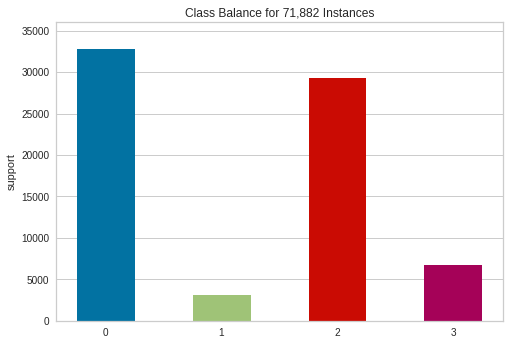

In [ ]:
class_balance(y_train_upsampled)

In [ ]:

from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y_train)

In [ ]:
from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X_train_upsamp, Y_train_upsamp = oversample.fit_resample(X_train, y)
sm = SMOTE({0:33444, 1:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, y)


/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 0 will be larger than the number of samples in the majority class (class #0 -> 32788)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 1 will be larger than the number of samples in the majority class (class #0 -> 32788)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 2 will be larger than the number of samples in the majority class (class #0 -> 32788)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 3 will be larger than the number of samples in the majority class (class #0 -> 32788)

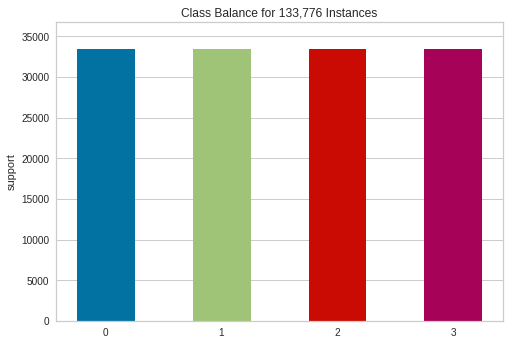

In [ ]:
class_balance(Y_train_upsamp)

In [ ]:
clf = RandomForestClassifier()

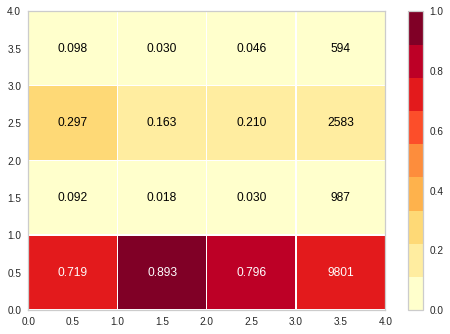

In [ ]:
# compare both original training data and upsampled date in terms of classification metrics

def classification_report(X, y, model):
    
    """
    Create yellowbrick classificaiton report visualization to assess classifier performance
    
    Args:
        X: features for model building
        y: target variable
        model: Classifier model
    
    Returns:
        viz_show: yellowbrick ClassificationReport visualization output
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)
    return visualizer.score(X_test, y_test)
    # viz_show = visualizer.show()
    # return viz_show

classification_report_ = classification_report(X_train, y_train, clf)
# classification_report_upsampled = classification_report(X_train_upsampled, y_train_upsampled, clf)
# classification_report_upsam = classification_report(X_train_upsamp, Y_train_upsamp, clf)

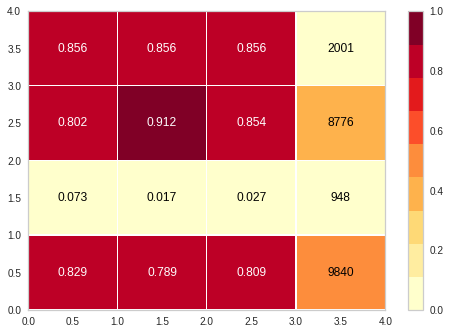

In [ ]:
classification_report_upsampled = classification_report(X_train_upsampled, y_train_upsampled, clf)


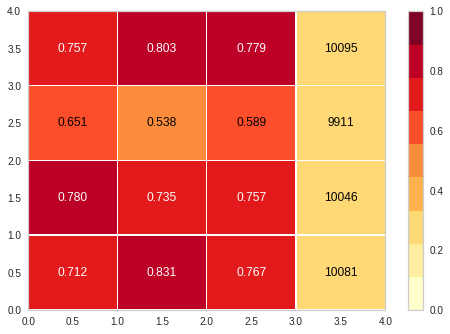

In [ ]:
classification_report_upsam = classification_report(X_train_upsamp, Y_train_upsamp, clf)

In [ ]:
# visualize performance measured by Area Under the Curve ("AUC") with ROC Curves
from yellowbrick.classifier.rocauc import roc_auc
def rocauc(X, y, model):
    """
    Create yellowbrick ROC Curve visualization to assess classifier performance
    Args:
        X: features for model building
        y: target variable
        model: Classifier model
    Returns:
        viz_show: yellowbrick ROCAUC visualization output
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    return roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=classes)

    # visualizer = ROCAUC(model, classes=classes, support=True)
    # visualizer.fit(X_train, y_train)
    # return visualizer.score(X_test, y_test)

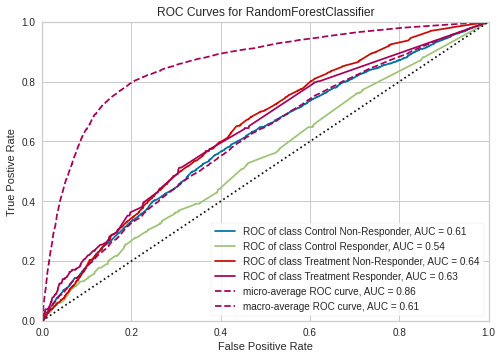

In [ ]:
rocauc_ = rocauc(X_train, y_train, clf)


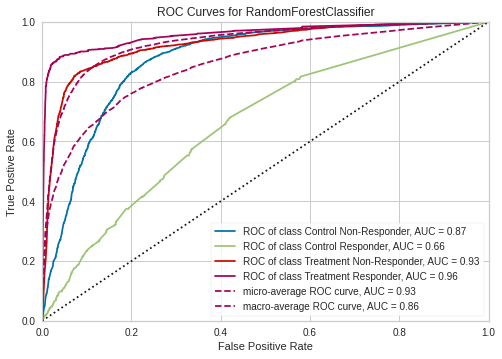

In [ ]:
rocauc_upsampled = rocauc(X_train_upsampled, y_train_upsampled, clf)

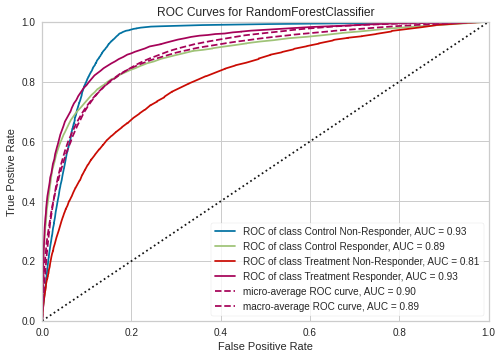

In [ ]:
rocauc_upsampled = rocauc(X_train_upsamp, Y_train_upsamp, clf)

# -------------------------------------------------------------------------------------------
# Uplift Model using sklearn from Vigneshsab et al., 

In [ ]:
train, test = train_test_split(clean_df, test_size=0.3, random_state=42)

In [ ]:
cpgn=['age','income','days_as_member','difficulty','duration','web','email','mobile', 'social', 'gender_M', 'gender_O', 'offer_type_discount', 'offer_type_informational']

Y_test = test['target_class']
X_test = test[cpgn]

In [ ]:
train.head()

,age,income,days_as_member,difficulty,duration,web,email,mobile,social,outcome,treatment,target_class,gender_M,gender_O,offer_type_discount,offer_type_informational
272649,42,48000.0,1539,5.0,5.0,1,1,1,1,0.0,0.0,0,1,0,0,0
87416,55,103000.0,1551,10.0,10.0,1,1,1,1,1.0,0.0,1,0,0,1,0
130300,77,37000.0,1032,5.0,7.0,1,1,1,0,0.0,1.0,2,0,0,0,0
154992,61,58000.0,773,10.0,7.0,0,1,1,1,0.0,0.0,0,1,0,0,0
229432,85,77000.0,1379,10.0,5.0,1,1,1,1,0.0,0.0,0,0,0,0,0


In [ ]:
train, valid = train_test_split(train, test_size=0.2,random_state=42)

cpgn=['age','income','days_as_member','difficulty','duration','web','email','mobile', 'social', 'gender_M', 'gender_O', 'offer_type_discount', 'offer_type_informational']

Y_train = train['target_class']
X_train = train[cpgn]

Y_valid = valid['target_class']
X_valid = valid[cpgn]

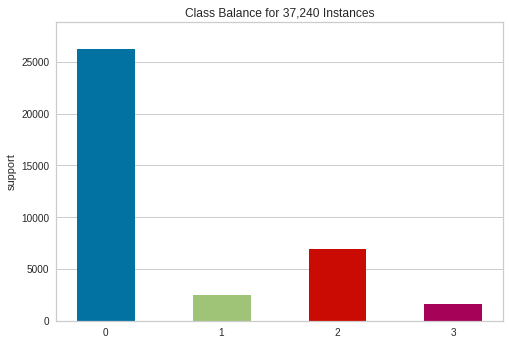

In [ ]:
from yellowbrick.target import class_balance
class_balance(Y_train);

In [ ]:
# up sample with SMOTE
sm = SMOTE({0:33444, 1:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=cpgn)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 0 will be larger than the number of samples in the majority class (class #0 -> 26236)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 1 will be larger than the number of samples in the majority class (class #0 -> 26236)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 2 will be larger than the number of samples in the majority class (class #0 -> 26236)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 3 will be larger than the number of samples in the majority class (class #0 -> 26236)

3    33444
2    33444
1    33444
0    33444
dtype: int64

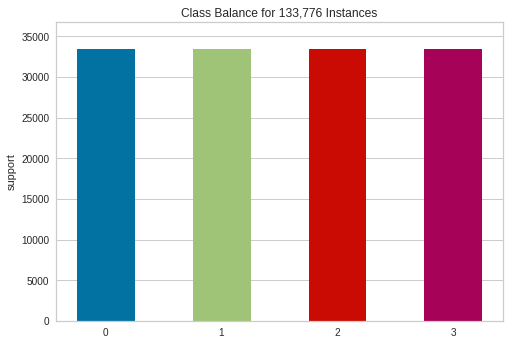

In [ ]:
class_balance(Y_train_upsamp);

In [ ]:
import xgboost as xgb
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          
                                  max_depth = 8,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[0]	validation_0-mlogloss:1.34122	validation_1-mlogloss:1.3221
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.30264	validation_1-mlogloss:1.26853
[2]	validation_0-mlogloss:1.2693	validation_1-mlogloss:1.22264
[3]	validation_0-mlogloss:1.24052	validation_1-mlogloss:1.18407
[4]	validation_0-mlogloss:1.21486	validation_1-mlogloss:1.15014
[5]	validation_0-mlogloss:1.19211	validation_1-mlogloss:1.12026
[6]	validation_0-mlogloss:1.17203	validation_1-mlogloss:1.0943
[7]	validation_0-mlogloss:1.15365	validation_1-mlogloss:1.07128
[8]	validation_0-mlogloss:1.13708	validation_1-mlogloss:1.05121
[9]	validation_0-mlogloss:1.12208	validation_1-mlogloss:1.03336
[10]	validation_0-mlogloss:1.10858	validation_1-mlogloss:1.01725
[11]	validation_0-mlogloss:1.09596	validation_1-mlogloss:1.00291
[12]	validation_0-mlogloss:1.08477	validation_1-mlogloss:0.99048
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

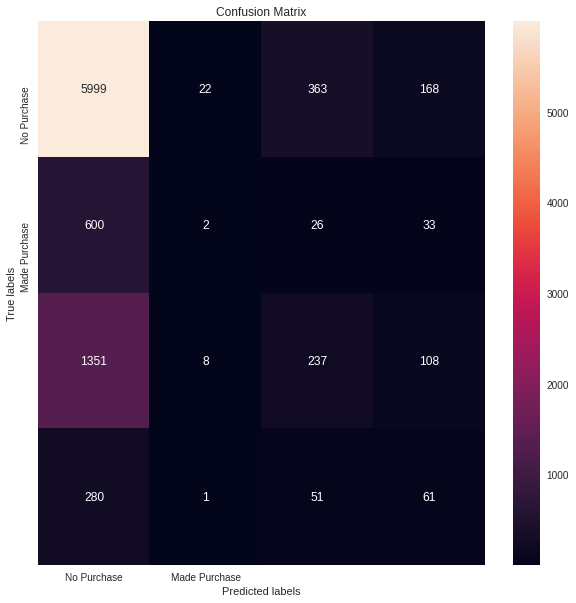

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [ ]:
# added this function to test our irr and nlr on the validation set
cpgn=['age','income','days_as_member','difficulty','duration','web','email','mobile', 'social', 'gender_M', 'gender_O', 'offer_type_discount', 'offer_type_informational']
def valid_results(promotion_strategy, valid_data, features):
    df = valid_data[features]
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 1)]    
    nir = score(score_df)
    print()
    print('Your Revenue generated with this strategy is {:0.2f}.'.format(nir))
    print()
    return nir

In [ ]:
def score(df, promo_pred_col = 'treatment'):
    n_treat       = df.loc[df[promo_pred_col] == 1,:].shape[0] # Size of treatment group (n)
    n_control     = df.loc[df[promo_pred_col] == 0,:].shape[0] # Size of control group (n)
    n_treat_purch = df.loc[df[promo_pred_col] == 1, 'outcome'].sum() # if a customer made a purchase during a promo, what was his reponse (summed up over the whole group)
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 0, 'outcome'].sum() # if a customer DID NOT make a purchase during a promo, what was his reponse (summed up over the whole group)
    nir = 11*n_treat_purch - 3 * n_treat + 11*n_ctrl_purch # nir = 11*% of customer that made a purchase and responded to an AD
                                                          # - 3* size of the treatment group + 11* Customers that DID NOT make a purchase but got an AD
    return (nir)

def test_results(promotion_strategy, test, features):
    test_data = test
    df = test_data[features]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 1)]    
    nir = score(score_df)
    print()
    print('Your Revenue generated with this strategy is {:0.2f}.'.format(nir))
    print()

In [ ]:
def promotion_strategy(df):
    '''     
    Ex:
    INPUT: df
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    OUTPUT: promotion
    
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    promotion = []
    for pred in pred:
        if pred == 0:
            promotion.append(1)
        else:
            promotion.append(0)
    promotion = np.array(promotion)
    return promotion


In [ ]:
valid_results(promotion_strategy, valid, cpgn)


Your Revenue generated with this strategy is 4787.00.



4787.0

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy, test, cpgn)


Your Revenue generated with this strategy is 10287.00.



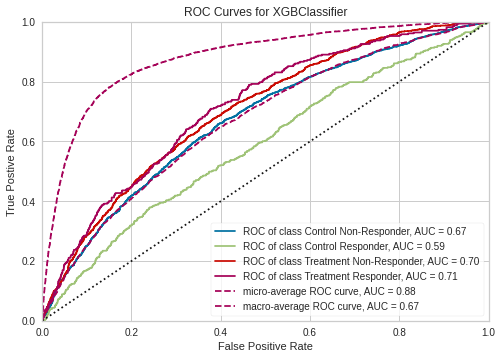

In [ ]:
roc_auc(model, X_train, Y_train, X_test=X_valid, y_test=Y_valid, classes=classes)

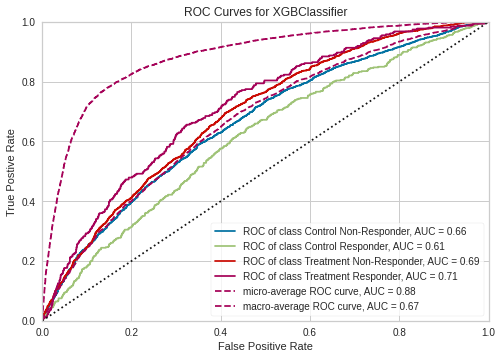

In [ ]:
roc_auc(model, X_train, Y_train, X_test=X_test, y_test=Y_test, classes=classes)